In [2]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# PARTE 2 - 1 Baixe os dados disponibilizados na plataforma Kaggle sobre dados sócio-econômicos 
# e de saúde que determinam o índice de desenvolvimento de um país. 
# Esses dados estão disponibilizados através do link: 
# https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data
path = kagglehub.dataset_download("rohan0301/unsupervised-learning-on-country-data")

# Carregar os dados
df = pd.read_csv(path+"\\Country-data.csv", sep = ",")

# PARTE 2 - 2 Quantos países existem no dataset?
print('Qtde Países no dataset: ', df['country'].count())

c:\ProgramData\miniconda3\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Qtde Países no dataset:  167


In [3]:
#VERIFICANDO SE EXISTEM VALORES
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [4]:
# Remover colunas não numéricas, caso existam (ex: nomes dos países)
X = df.select_dtypes(include=[np.number])

In [5]:
# PARTE 2 - 3 Os dados possuem variação alta, presença de outliers e diferença de escala entre variáveis
# TRATAMENTO DE OUTLIERS - Foi preciso aplicar logaritmos nas colunas que possuiam outliers:
# 'child_mort', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp', 'exports', 'imports'
# verificando se o valor era negativo antes de aplicar o logaritmo

In [6]:
# Tratar outliers
cols_to_log = ['child_mort', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp', 'exports', 'imports']
for col in cols_to_log:
    min_val = X[col].min()
    if min_val <= 0:
        X[col] = np.log1p(X[col] + abs(min_val) + 1)
    else:
        X[col] = np.log1p(X[col])

In [7]:
# PARTE 2 - 3 Os dados possuem variação alta, presença de outliers e diferença de escala entre variáveis
# NORMALIZAÇÃO - Foi preciso normalizar os dados para reduzir a amplitude dos valores
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

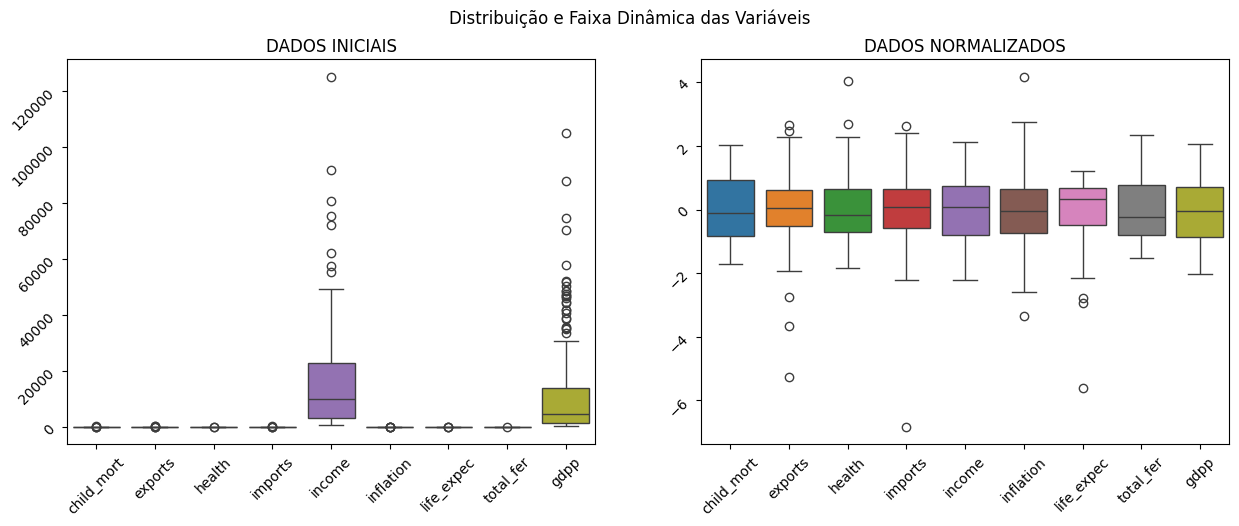

In [9]:
f, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(data=df.drop('country', axis=1), ax=ax[0])
ax[0].set_title('DADOS INICIAIS')
ax[0].tick_params(labelrotation=45)

sns.boxplot(data=X_scaled_df, ax=ax[1])
ax[1].set_title('DADOS NORMALIZADOS')
ax[1].tick_params(labelrotation=45)

plt.suptitle('Distribuição e Faixa Dinâmica das Variáveis')
plt.show()

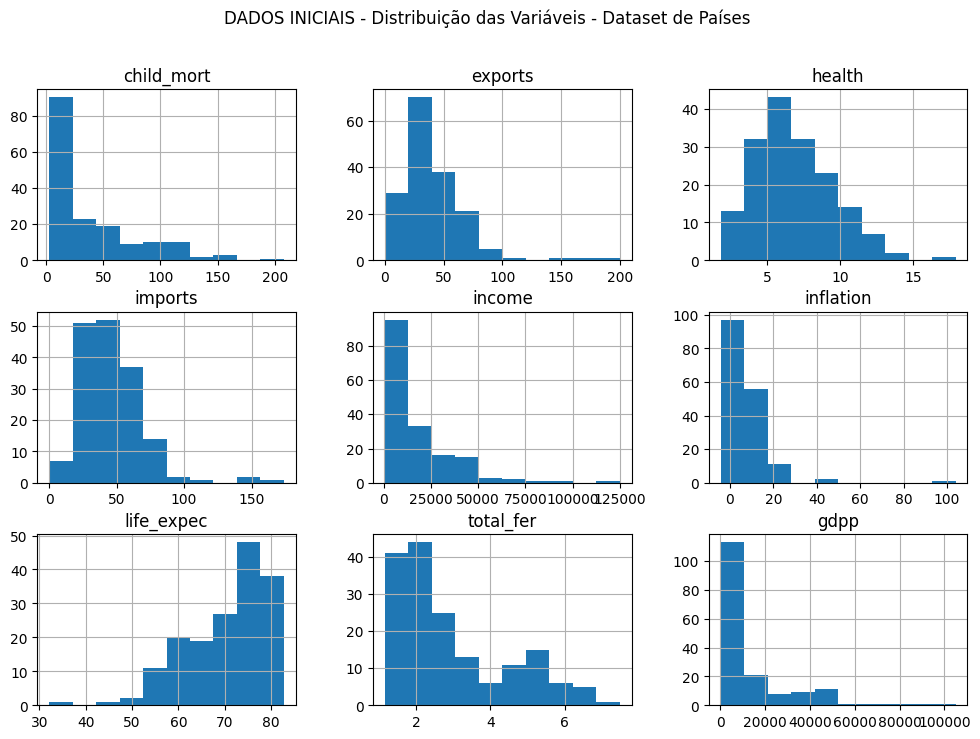

In [10]:
df.drop('country', axis=1).hist(figsize=(12,8))
plt.suptitle("DADOS INICIAIS - Distribuição das Variáveis - Dataset de Países")
plt.show()

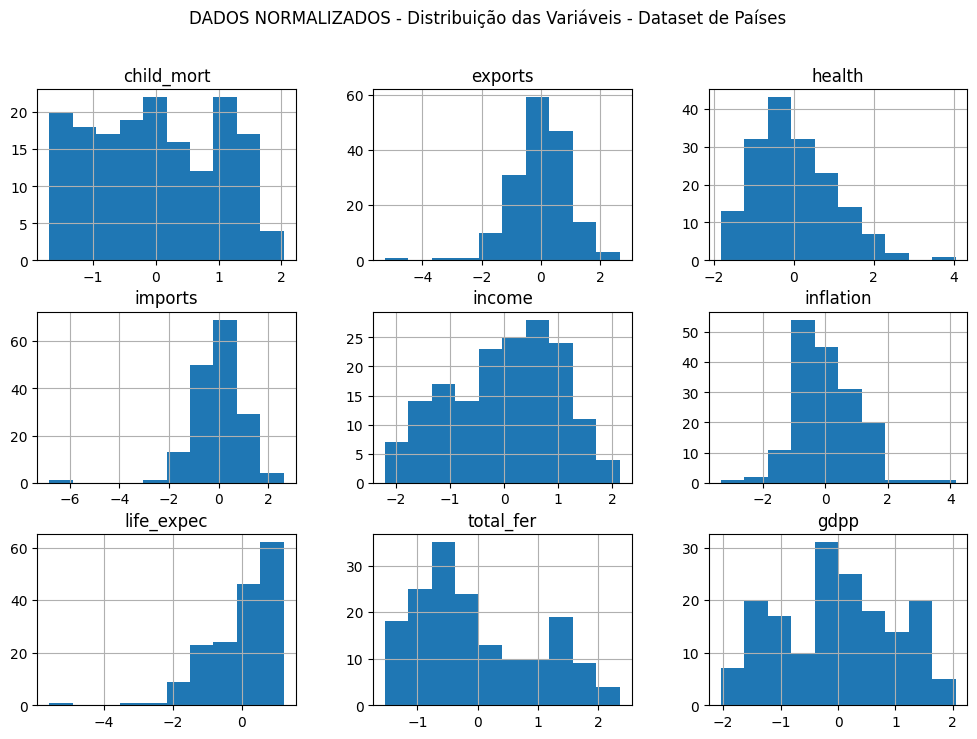

In [11]:
X_scaled_df.hist(figsize=(12,8))
plt.suptitle("DADOS NORMALIZADOS - Distribuição das Variáveis - Dataset de Países")
plt.show()

In [53]:
number_of_clusters = 3
random_seed = 42

hierarquical = AgglomerativeClustering(
    n_clusters=number_of_clusters, 
    linkage='ward', 
    metric='euclidean'
)

X_scaled_df['cluster_hierarquical'] = hierarquical.fit_predict(X_scaled)

kmeans = KMeans(
    n_clusters=number_of_clusters,
    random_state=random_seed
)

X_scaled_df['cluster_kmeans'] = kmeans.fit_predict(X_scaled)


In [54]:
[x for x in kmeans.cluster_centers_]

[array([ 0.15086131,  0.0763105 , -0.379608  , -0.06190568, -0.0094424 ,
         0.39751115,  0.04374347, -0.09688368, -0.12258755]),
 array([-1.06165075,  0.50957004,  0.51692257,  0.23047803,  0.95290478,
        -0.72519562,  0.82217375, -0.86209096,  1.01306748]),
 array([ 1.25683538, -0.82460639, -0.15628936, -0.22945857, -1.31558077,
         0.42025636, -1.21232574,  1.34711658, -1.23112663])]

In [55]:
[x[0] for x in kmeans.cluster_centers_]

[np.float64(0.15086131193119143),
 np.float64(-1.0616507542022464),
 np.float64(1.2568353788032214)]

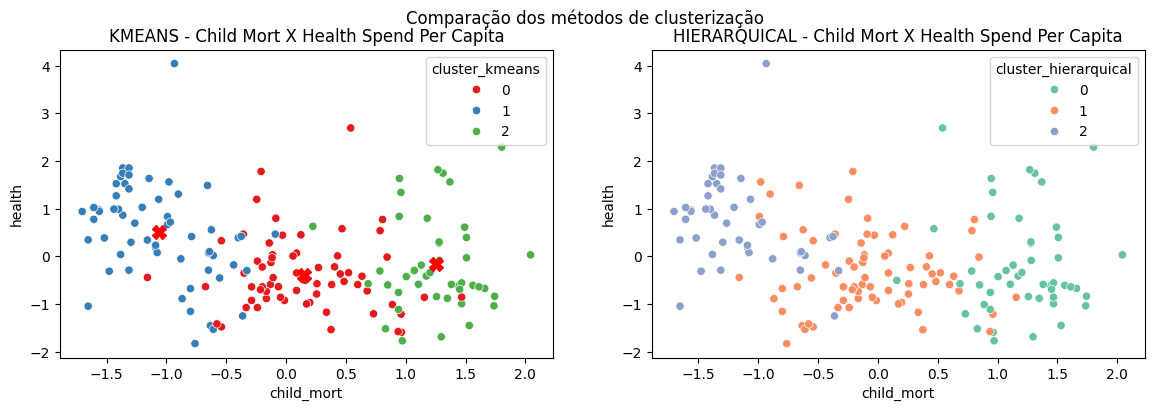

In [64]:
f, ax = plt.subplots(1, 2, figsize=(14,4))

x_column = 'child_mort'
y_column = 'health'
pos_for_x_column = 0
pos_for_y_column = 2

sns.scatterplot(data=X_scaled_df, x=x_column, y=y_column, hue=X_scaled_df['cluster_kmeans'], palette='Set1', ax=ax[0])
ax[0].set_title('KMEANS - Child Mort X Health Spend Per Capita')
ax[0].plot(
    [x[pos_for_x_column] for x in kmeans.cluster_centers_],
    [x[pos_for_y_column] for x in kmeans.cluster_centers_],
    'X',
    color='red',
    markersize=10,
)

sns.scatterplot(data=X_scaled_df, x=x_column, y=y_column, hue=X_scaled_df['cluster_hierarquical'], palette='Set2', ax=ax[1])
ax[1].set_title('HIERARQUICAL - Child Mort X Health Spend Per Capita')

plt.suptitle('Comparação dos métodos de clusterização')
plt.show()


In [ ]:
print("\nDistribuição dos clusters (K-Means):")
print(df['cluster_kmeans'].value_counts())

print("\nDistribuição dos clusters (Hierárquico):")
print(df['cluster_hierarquical'].value_counts())

In [ ]:
# O AgglomerativeClustering não gera dendrograma diretamente, então usamos linkage
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=45., leaf_font_size=10.)
plt.title("Dendrograma - Clusterização Hierárquica")
plt.xlabel("Amostras")
plt.ylabel("Distância Euclidiana")
plt.show()

In [ ]:
pd.crosstab(df['cluster_kmeans'], df['cluster_hierarquical'])